### Preliminaries

In [1]:
# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from opc_python.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from opc_python.gerkin import dream,fit1,fit2,params

In [3]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [4]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
num_descriptors = len(perceptual_headers[6:])
num_subjects = 49
print('There are %d different perceptual descriptors and %d different subjects' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [6]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [7]:
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
print("We have perceptual data for %d unique molecules" % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

We have perceptual data for 338 unique molecules
138 are left out for testing in the competition; half of these (69) are used for the leaderboard.


In [8]:
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)" % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules)


In [9]:
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
DATA = '/Users/rgerkin/Dropbox/science/olfaction-prediction/data/'
import pandas

In [10]:
episuite = pandas.read_table('%s/DREAM_episuite_descriptors.txt' % DATA)
episuite.iloc[:,49] = 1*(episuite.iloc[:,49]=='YES ')
episuite.iloc[:,49]
episuite = episuite.iloc[:,2:].as_matrix()
episuite.shape

(476, 62)

In [11]:
verbal = pandas.read_table('%s/name_features.txt' % DATA, sep='\t', header=None)
verbal = verbal.as_matrix()[:,1:]
verbal.shape

(476, 11786)

In [12]:
morgan = pandas.read_csv('%s/morgan_sim.csv' % DATA)
morgan = morgan.as_matrix()[:,1:]
morgan.shape

(476, 2437)

In [13]:
with open('%s/derived/nspdk_r3_d4_unaug.svm' % DATA) as f:
    nspdk_dict = {}
    i = 0
    while True:
        x = f.readline()
        if(len(x)):
            key_vals = x.split(' ')[1:]
            for key_val in key_vals:
                key,val = key_val.split(':')
                if key in nspdk_dict:
                    nspdk_dict[key][all_CIDs[i]] = val
                else:
                    nspdk_dict[key] = {all_CIDs[i]:val}
            i+=1
            if i == len(all_CIDs):
                break
        else:
            break
nspdk_dict = {key:value for key,value in nspdk_dict.items() if len(value)>1}

In [14]:
nspdk = np.zeros((len(all_CIDs),len(nspdk_dict)))
for j,(feature,facts) in enumerate(nspdk_dict.items()):
    for CID,value in facts.items():
        i = all_CIDs.index(CID)
        nspdk[i,j] = value
nspdk.shape

(476, 6163)

In [15]:
nspdk_gramian = pandas.read_table('%s/derived/nspdk_r3_d4_unaug_gramian.mtx' % DATA, delimiter=' ', header=None)
nspdk_gramian = nspdk_gramian.as_matrix()[:len(all_CIDs),:]
nspdk_gramian.shape

(476, 2437)

In [16]:
molecular_data_types = ['dragon','dragon+episuite+morgan+nspdk+gramian']
molecular_data_extended = molecular_data.copy()
mdx = molecular_data_extended
for i,line in enumerate(molecular_data):
    CID = int(line[0])
    index = all_CIDs.index(CID)
    mdx[i] = line + list(episuite[index]) + list(morgan[index]) + list(nspdk[index]) + list(nspdk_gramian[index])

### Create Molecular Matrix

In [17]:
X_training,good1,good2,means,stds,imputer = dream.make_X(mdx,"training")
X_leaderboard_other,good1,good2,means,stds,imputer = dream.make_X(mdx,"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_int,good1,good2,means,stds,imputer = dream.make_X(mdx,"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_testset_other,good1,good2,means,stds,imputer = dream.make_X(mdx,"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_testset_int,good1,good2,means,stds,imputer = dream.make_X(mdx,"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_all,good1,good2,means,stds,imputer = dream.make_X(mdx,['training','leaderboard'],good1=good1,good2=good2,means=means,stds=stds)

There are now 676 molecular vectors of length 15970, one for each molecule and dilution
The X matrix now has shape (676x13914) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 15970, one for each molecule and dilution
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 15970, one for each molecule and dilution
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 15970, one for each molecule and dilution
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 15970, one for each molecule and dilution
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
There are now 814 molecular vectors of length 15970, one for each molecule and dilution
The X matrix now has shape (814x13914) molecu

In [18]:
Y_training_imp,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')
Y_training_mask,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one

In [19]:
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [20]:
Y_leaderboard_noimpute,_ = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer=None)

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [21]:
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [22]:
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


### Data preparation

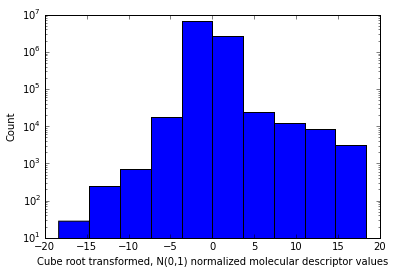

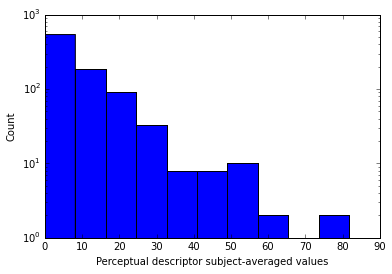

In [23]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_training.ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(Y_training_imp['mean_std'][:21].ravel())
plt.yscale('log')
plt.ylabel('Count')
_ = plt.xlabel('Perceptual descriptor subject-averaged values')

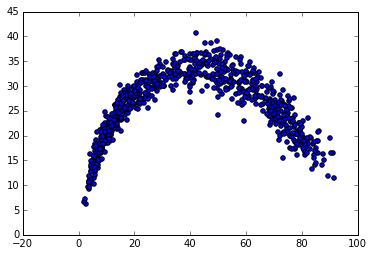

In [24]:
# A typical relationship between the mean and the variance.  
plt.scatter(Y_all_mask['mean_std'][:,0],Y_all_mask['mean_std'][:,21])

## Fitting and Generating Submission Files

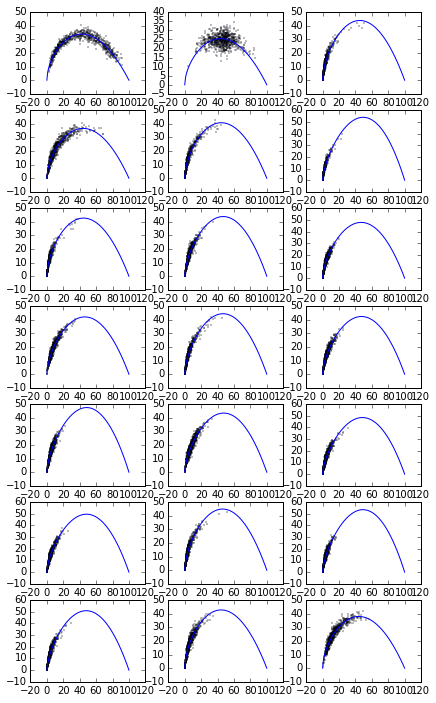

In [25]:
def f_transformation(x, k0=1.0, k1=1.0):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))
    
def sse(x, mean, stdev):
    predicted_stdev = f_transformation(mean, k0=x[0], k1=x[1])
    #predicted_mean = f_transformation2(predicted[i], k0=x[0], k1=x[1], k2=x[2])
    sse = np.sum((predicted_stdev - stdev)**2)
    return sse
    
fig,axes = plt.subplots(7,3,figsize=(7,12))
ax = axes.flat
trans_params = {col:None for col in range(21)}
from scipy.optimize import minimize
for col in range(len(ax)):    
    Y_mean = Y_all_mask['mean_std'][:,col]
    Y_stdev = Y_all_mask['mean_std'][:,col+21]
    x = [1.0,1.0]
    res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
    trans_params[col] = res.x # We will use these for our transformations.  
    ax[col].scatter(Y_mean,Y_stdev,s=0.1)
    x_ = np.linspace(0,100,100)
    ax[col].plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]))#, k2=res.x[2]))

In [92]:
n_estimators = 1000
cols = range(42)
def get_params(i):
    return {col:params.best[col][i] for col in cols}

use_et = get_params(0)
max_features = get_params(1)
max_depth = get_params(2)
min_samples_leaf = get_params(3)
trans_weight = get_params(4)
regularize = get_params(4)
use_mask = get_params(5)
for col in range(21):
    trans_weight[col] = trans_weight[col+21]

In [68]:
# Fit training data.  Ignoring warning that arises if too few trees are used.  
rfcs_leaderboard,score,rs = fit2.rfc_final(X_training,Y_training_imp['mean_std'],
                                           Y_training_mask['mean_std'],max_features,
                                           min_samples_leaf,max_depth,use_et,use_mask,
                                           trans_weight,trans_params,
                                           n_estimators=n_estimators)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
For subchallenge 2:
	Score = 9.71
	int_mean = 1.000
	int_sigma = 0.936
	ple_mean = 0.699
	ple_sigma = 0.240
	dec_mean = 0.516
	dec_sigma = 0.420


In [69]:
loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,
                              'leaderboard',2,Y_test=Y_leaderboard_noimpute,
                              write=True,trans_weight=trans_weight,trans_params=trans_params)

Score: 8.991304; rs = 0.646,0.576,0.569,0.436,0.132,0.498
Wrote to file with suffix "1446286249"


{'mean_std': array([[ 71.37426531,  41.48437755,   2.81302028, ...,   8.62841484,
          13.39748908,  27.39827798],
        [ 59.17583673,  44.88153061,   1.75245157, ...,   9.75540249,
          15.78022703,  29.71372428],
        [ 21.75810204,  38.11428571,   1.84919165, ...,   8.01600097,
          10.26052088,  24.65698316],
        ..., 
        [ 35.76002041,  43.43406122,   1.85339762, ...,  15.45011246,
          16.27906011,  23.01509148],
        [ 40.61036735,  45.11128571,   2.67790415, ...,  10.26927896,
          20.513681  ,  23.91949256],
        [ 33.09271429,  56.0882449 ,   2.04220163, ...,  25.6146265 ,
          18.56653544,  24.24662054]]), 'subject': {}}

In [ ]:
rfcs,score,rs = fit2.rfc_final(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                               max_features,min_samples_leaf,max_depth,use_et,use_mask,
                               trans_weight,trans_params,n_estimators=n_estimators)

In [71]:
loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',2,write=True,
                              trans_weight=trans_weight,trans_params=trans_params)

Wrote to file with suffix "1446300940"


{'mean_std': array([[ 21.5212449 ,  39.67705102,   1.90316735, ...,  10.20082525,
          10.39524613,  31.58733494],
        [ 28.02379592,  44.73617347,   2.0750604 , ...,   8.11174684,
          10.2209698 ,  20.72358021],
        [ 59.26867347,  30.53020408,   1.8075775 , ...,   8.07846887,
          10.38745326,  25.86262462],
        ..., 
        [ 52.92461224,  51.47581633,   2.29435162, ...,  33.66411719,
          18.80143892,  20.72935382],
        [ 32.9845102 ,  49.18562245,   2.00685376, ...,  14.8513966 ,
          16.9114995 ,  23.20248081],
        [ 23.30469388,  49.45347959,   1.8899173 , ...,  22.32860467,
          22.23431678,  33.03462155]]), 'subject': {}}

In [97]:
n_estimators = 100

# Fit training data for subchallenge 1.  
# Ignoring warning that arises if too few trees are used.  
rfcs_leaderboard,score,rs = fit1.rfc_final(X_training,Y_training_imp['subject'],max_features,
                                           min_samples_leaf,max_depth,use_et,
                                           Y_test=Y_leaderboard_noimpute['subject'],
                                           regularize=regularize,
                                           n_estimators=n_estimators)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
For subchallenge 1:
	Score = 34.24
	int = 0.843
	ple = 0.350
	dec = 0.159


In [102]:
loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,
                              'leaderboard',1,Y_test=Y_leaderboard_noimpute,
                              write=True,regularize=regularize)

Score: 26.610701; rs = 0.428,0.300,0.168
Wrote to file with suffix "1446361058"


{'subject': {1: array([[ 61.52571429,  38.98571429,   2.22580878, ...,   1.1833913 ,
            3.26311027,  15.73098165],
         [ 58.27306122,  46.37285714,   1.45792691, ...,   1.44274672,
            2.74011324,  12.21713042],
         [ 23.53102041,  47.12071429,   1.84712711, ...,   1.37401704,
            1.90863325,   3.99038286],
         ..., 
         [ 33.79469388,  45.26857143,   1.38054872, ...,   4.43142016,
            4.47421172,   6.10529865],
         [ 39.85020408,  41.83214286,   5.2641683 , ...,   2.06083539,
            7.41781768,  15.86989997],
         [ 42.85102041,  51.28214286,   3.02592687, ...,  10.22138128,
            5.26708216,  10.44196627]]),
  2: array([[ 65.08571429,  50.53571429,   2.69711549, ...,   1.19356999,
            3.2791037 ,  13.58606141],
         [ 62.71306122,  44.90285714,   1.51955304, ...,   1.44292541,
            3.02199986,  13.0644761 ],
         [ 26.35102041,  38.90071429,   2.20776715, ...,   1.37419573,
            1.9

In [ ]:
n_estimators = 50

# Fit all data for subchallenge 1.  
rfcs1,score1,rs1 = fit1.rfc_final(X_all,Y_all_imp['subject'],max_features,
                                           min_samples_leaf,max_depth,use_et,
                                           regularize=regularize,
                                           n_estimators=n_estimators)

In [ ]:
loading.make_prediction_files(rfcs1,X_testset_int,X_testset_other,
                              'leaderboard',1,write=True,regularize=regularize)